In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))


print("¿GPU disponible?:", tf.config.list_physical_devices('GPU'))

2024-11-04 09:24:22.111481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 09:24:22.279390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 09:24:22.344891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 09:24:22.363347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 09:24:22.468481: I tensorflow/core/platform/cpu_feature_guar

¿GPU disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lingfeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
I0000 00:00:1730708664.656834    4180 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730708664.800088    4180 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730708664.800296    4180 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Docume

In [2]:
train = Loader.load_NLP()[:20000]

/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

In [3]:
descriptions = [col for col in train.columns if "description" in col]

print(descriptions)

def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
#train[descriptions].apply(lambda col: col.apply(lambda x: type(x).__name__).value_counts())

#descriptions.append("idx")
#descriptions.append("price")
#descriptions.append("km")

['motor_description', 'transmission_description', 'parking_sensors_description', 'Exterior_Llantas_description', 'Exterior_Molduras_description', 'Exterior_Neumáticos_description', 'Exterior_Puerta_description', 'Exterior_Retrovisor_description', 'Confort_Volante_description', 'seat_description', 'head_supporter_description']


In [4]:
filtered_columns = ["price", "km", "fuelType", "full_description"]
train = train[filtered_columns]
train.dropna(inplace=True)
train

,price,km,fuelType,full_description
idx,,,,
47257,8490,82801.0,Diésel,"Motor de 1,5 litros ( 1.461 cc ) , 4 cilindros..."
47258,51000,112000.0,Diésel,"Motor de 2,0 litros ( 1.950 cc ) , cuatro cili..."
47259,11950,223700.0,Diésel,"Motor de 2,7 litros ( 2.720 cc ) , 6 cilindros..."
47260,17000,150000.0,Diésel,"Motor de 2,0 litros ( 1.999 cc ) , cuatro cili..."
47261,21990,130000.0,Gasolina,"Motor de 2,0 litros ( 1.984 cc ) , cuatro cili..."
...,...,...,...,...
67306,19499,83000.0,Gasolina,"Motor de 1,0 litros ( 999 cc ) , tres cilindro..."
67307,19000,186000.0,Diésel,"Motor de 2,0 litros ( 1.997 cc ) , cuatro cili..."
67308,27300,0.0,Híbrido,"Motor de 1,0 litros ( 998 cc ) , tres cilindro..."


In [5]:
#Parameters
verb_size = 150

In [6]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales (pero mantener los números)
    text = text.lower()
    text = re.sub(r'[^\w\s\d]', '', text)  # Eliminar signos de puntuación, pero mantener números
    tokens = text.split()
    
    # Filtrar tokens, eliminando las stopwords
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    
    return filtered_tokens

train['tokens'] = train['full_description'].apply(preprocess_text)
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=verb_size, window=1, min_count=3, workers=8)
word_vectors = model_w2v.wv

def get_average_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 
train['embedding'] = train['tokens'].apply(lambda x: get_average_embedding(x, word_vectors))

In [7]:
x_km = train['km'].to_numpy().reshape(-1, 1)
scaler_km = StandardScaler()
x_km_scaled = scaler_km.fit_transform(x_km)

y = train['price'].to_numpy()
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [8]:
# Load data (assuming df is your DataFrame containing the required columns)
texts = train['full_description'].values  # descriptions
embeddings = train['embedding'].values  # embeddings

# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=verb_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences,  maxlen=verb_size, padding='post')

In [9]:
# Split data into training and testing sets
train_data, test_data, train_embeddings, test_embeddings, train_prices, test_prices, train_km, test_km = train_test_split(
    data, embeddings, train['price'], train['km'], test_size=0.2, random_state=42, stratify=train['fuelType'])

# Normalize embeddings
train_embeddings = tf.keras.utils.normalize(train_embeddings)
test_embeddings = tf.keras.utils.normalize(test_embeddings)
train_embeddings = np.transpose(train_embeddings)
test_embeddings = np.transpose(test_embeddings)

In [10]:
print(test_prices.shape)
print(train['km'].shape)
print(train_km.shape)
print(test_km.shape)

(4000,)
(20000,)
(16000,)
(4000,)


In [11]:
def process_embedding(embed):
    standard_length = verb_size
    flat_embed = np.concatenate([np.array(e).flatten() for e in embed])  # Flatten
    # Pad with zeros or truncate to the standard length
    if len(flat_embed) > standard_length:
        return flat_embed[:standard_length]
    elif len(flat_embed) < standard_length:
        return np.pad(flat_embed, (0, standard_length - len(flat_embed)), mode='constant')
    return flat_embed

In [12]:
train_embeddings = np.array([process_embedding(e) for e in train_embeddings], dtype=np.float32)
train_embeddings = tf.convert_to_tensor(train_embeddings, dtype=tf.float32)

I0000 00:00:1730708697.767743    4180 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730708697.768107    4180 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730708697.768215    4180 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730708697.839748    4180 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [13]:
test_embeddings = np.array([process_embedding(e) for e in test_embeddings], dtype=np.float32)
test_embeddings = tf.convert_to_tensor(test_embeddings, dtype=tf.float32)

In [14]:
train_data = tf.convert_to_tensor(train_data, dtype=tf.int32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.int32)

In [15]:
train_prices = tf.convert_to_tensor(train_prices, dtype=tf.float32)
test_prices = tf.convert_to_tensor(test_prices, dtype=tf.float32)

In [16]:
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)

In [17]:
train_data.shape

TensorShape([16000, 150])

In [36]:
# Text input branch
text_input = Input(shape=(train_data.shape[1],), dtype='int32')
text_embed_layer = Embedding(input_dim=verb_size, output_dim=verb_size, input_length=train_data.shape[1])
text_embed = text_embed_layer(text_input)
lstm_out = LSTM(128)(text_embed)

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
# Embedding input branch
embed_input = Input(shape=(train_embeddings.shape[1],), dtype = 'int32')
dense_embed = Dense(128, activation='relu')(embed_input)

# KM branch
input_km = Input(shape=(1,), name='km_input')
km_processed = Dense(32, activation='linear')(input_km)

# Concatenate both branches
concat = Concatenate()([lstm_out, dense_embed, km_processed])
hidden = Dense(256, activation='relu')(concat)
output = Dense(1, activation='linear')(hidden)  # Output layer for price prediction

model = Model(inputs=[text_input, embed_input, input_km], outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 150, 150)  │     22,500 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    142,848 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     19,328 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 288)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ dense_11[0][0],   │
│                     │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     73,984 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        257 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 258,981 (1011.64 KB)

 Trainable params: 258,981 (1011.64 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
print(train_data.shape)      # Should be (number of samples, sequence length)
print(train_embeddings.shape)
print(train_km.shape)

(16000, 150)
(16000, 150)
(16000,)


In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error', 'huber', "mean_absolute_percentage_error"])

In [46]:
# Train the model
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit([train_data, train_embeddings, train_km], train_prices,
          validation_data=([test_data, test_embeddings, test_km], test_prices),
          epochs=15, batch_size=32)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/15


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_9', 'keras_tensor_22', 'km_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18285.0625 - mean_absolute_error: 18285.0625

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_9', 'keras_tensor_22', 'km_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 18283.8340 - mean_absolute_error: 18283.8340 - val_loss: 17618.7695 - val_mean_absolute_error: 17618.7695
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 17501.5723 - mean_absolute_error: 17501.5723 - val_loss: 16491.0098 - val_mean_absolute_error: 16491.0098
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 16467.4863 - mean_absolute_error: 16467.4863 - val_loss: 14803.8076 - val_mean_absolute_error: 14803.8076
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 13997.3291 - mean_absolute_error: 13997.3291 - val_loss: 12420.1123 - val_mean_absolute_error: 12420.1123
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 10354.3232 - mean_absolute_error: 10354.3232 - val_loss: 7822.0234 - val_mean_absolute_error: 7822.0234
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8442.0371 - mean_absolute_error: 8442.0371 - val_loss: 6710.8862 - val_mean_absolute_error: 6710.8862
Epoch 7/15
500/5

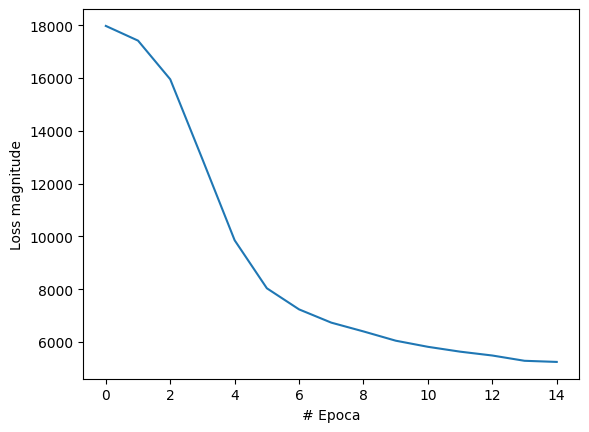

In [47]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

In [48]:
test_loss, test_mse = model.evaluate([test_data, test_embeddings, test_km], test_prices)
print(f'Test MAE: {test_mse}')


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4644.9365 - mean_absolute_error: 4644.9365
Test MAE: 4721.40185546875


In [49]:
predicted_prices = model.predict([test_data, test_embeddings, test_km])

# Assuming test_prices is a 1D array, we can convert it to a DataFrame
results_df = pd.DataFrame({
    'Actual Price': test_prices,
    'Predicted Price': predicted_prices.flatten(),  # Flatten in case it's a 2D array
    'km' : test_km
})

# Display the first few rows of the DataFrame
print(results_df.head())

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_9', 'keras_tensor_22', 'km_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
       Actual Price  Predicted Price        km
idx                                           
48349       15900.0     16076.037109   80000.0
66241       21990.0     27261.468750   41620.0
59466       10990.0     14192.273438  167099.0
53063       11900.0      8706.503906  309000.0
55925       27900.0     28403.531250  209000.0
